<a href="https://colab.research.google.com/github/monicafar147/regression-predict-api-template/blob/Wright/cleaned.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Introduction


The aim of this notebook is to predict the estimated time of delivery of orders, from the point of driver pickup to the point of arrival at final destination from a logistics company, Sendy, based in Nairobi.

Sendy can improve their reliability and enhance their customer communication by providing an estimated time of delivery of orders through regression techniques used to model the delivery process.

Sendy is headquartered in Kenya and the data provided is based in Nairobi. The training dataset provided is a subset of over 21201 orders and only includes direct orders (i.e. Sendy “express” orders) with bikes in Nairobi.

# Body

## Imports

### Importing the libraries

In [0]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
%matplotlib inline
import math
from sklearn import metrics
from sklearn.model_selection import train_test_split

# Scaling
from sklearn.preprocessing import StandardScaler

# Machine learning models
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import Lasso

# Saving model with pickle
import pickle

sns.set(palette='pastel')

### Importing the data

In [0]:
train = pd.read_csv('https://raw.githubusercontent.com/monicafar147/regression-predict-api-template/master/Train.csv', 
                    parse_dates=['Pickup - Time', 'Placement - Time', 'Confirmation - Time', 'Arrival at Pickup - Time', 'Arrival at Destination - Time'],
                    index_col=0)
test = pd.read_csv('https://raw.githubusercontent.com/monicafar147/regression-predict-api-template/master/Test.csv',
                    parse_dates=['Pickup - Time', 'Placement - Time', 'Confirmation - Time'],
                    index_col=0)
riders = pd.read_csv('https://raw.githubusercontent.com/monicafar147/regression-predict-api-template/master/Riders.csv', index_col=0)

## EDA

In [0]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 21201 entries, Order_No_4211 to Order_No_9836
Data columns (total 28 columns):
 #   Column                                     Non-Null Count  Dtype         
---  ------                                     --------------  -----         
 0   User Id                                    21201 non-null  object        
 1   Vehicle Type                               21201 non-null  object        
 2   Platform Type                              21201 non-null  int64         
 3   Personal or Business                       21201 non-null  object        
 4   Placement - Day of Month                   21201 non-null  int64         
 5   Placement - Weekday (Mo = 1)               21201 non-null  int64         
 6   Placement - Time                           21201 non-null  datetime64[ns]
 7   Confirmation - Day of Month                21201 non-null  int64         
 8   Confirmation - Weekday (Mo = 1)            21201 non-null  int64         
 9   Co

At this stage, we notice that there are missing values from `Temperature` and `Precipitation in millimeters`.

In [0]:
train.describe()

,Platform Type,Placement - Day of Month,Placement - Weekday (Mo = 1),Confirmation - Day of Month,Confirmation - Weekday (Mo = 1),Arrival at Pickup - Day of Month,Arrival at Pickup - Weekday (Mo = 1),Pickup - Day of Month,Pickup - Weekday (Mo = 1),Arrival at Destination - Day of Month,Arrival at Destination - Weekday (Mo = 1),Distance (KM),Temperature,Precipitation in millimeters,Pickup Lat,Pickup Long,Destination Lat,Destination Long,Time from Pickup to Arrival
count,21201.000000,21201.000000,21201.000000,21201.000000,21201.000000,21201.000000,21201.000000,21201.000000,21201.000000,21201.000000,21201.000000,21201.000000,16835.000000,552.000000,21201.000000,21201.000000,21201.000000,21201.000000,21201.000000
mean,2.752182,15.653696,3.240083,15.653837,3.240225,15.653837,3.240225,15.653837,3.240225,15.653837,3.240225,9.506533,23.258889,7.905797,-1.281470,36.811264,-1.282581,36.811220,1556.920947
std,0.625178,8.798916,1.567295,8.798886,1.567228,8.798886,1.567228,8.798886,1.567228,8.798886,1.567228,5.668963,3.615768,17.089971,0.030507,0.037473,0.034824,0.044721,987.270788
min,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,11.200000,0.100000,-1.438302,36.653621,-1.430298,36.606594,1.000000
25%,3.000000,8.000000,2.000000,8.000000,2.000000,8.000000,2.000000,8.000000,2.000000,8.000000,2.000000,5.000000,20.600000,1.075000,-1.300921,36.784605,-1.301201,36.785661,882.000000
50%,3.000000,15.000000,3.000000,15.000000,3.000000,15.000000,3.000000,15.000000,3.000000,15.000000,3.000000,8.000000,23.500000,2.900000,-1.279395,36.807040,-1.284382,36.808002,1369.000000
75%,3.000000,23.000000,5.000000,23.000000,5.000000,23.000000,5.000000,23.000000,5.000000,23.000000,5.000000,13.000000,26.000000,4.900000,-1.257147,36.829741,-1.261177,36.829477,2040.000000
max,4.000000,31.000000,7.000000,31.000000,7.000000,31.000000,7.000000,31.000000,7.000000,31.000000,7.000000,49.000000,32.100000,99.100000,-1.147170,36.991046,-1.030225,37.016779,7883.000000


### Distribution of Target Variable

Text(0.5, 1.0, 'Delivery Time Distribution')

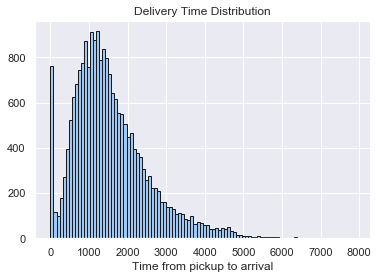

In [0]:
plt.hist(train['Time from Pickup to Arrival'], bins = 100, edgecolor = 'k')
plt.xlabel('Time from pickup to arrival') 
plt.title('Delivery Time Distribution')

The high distribution of very low values seems suspicious.

In [0]:
print('Time from pickup to arrival less than 60s:', len(train[train['Time from Pickup to Arrival'] < 60]))
print('Time from pickup to arrival of 1s: ', len(train[train['Time from Pickup to Arrival'] ==1]))

Time from pickup to arrival less than 60s: 740
Time from pickup to arrival of 1s:  37


`Time from pickup to arrival` of less than 60 seconds seems suspicious, especially 1 second. It is possible that riders may have forgotten to confirm the pickup on the app until they dropped off the parcel, resulting in this unrealistic time frame. These rows should be dropped because they will skew the data.

Text(0.5, 1.0, 'Delivery Time Distribution')

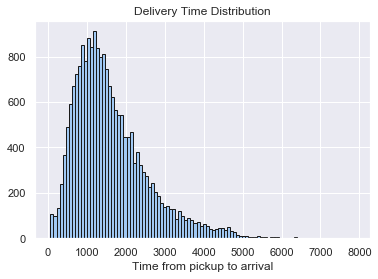

In [0]:
# Dropping rows where delivery time is less than 60s
orders = train[train['Time from Pickup to Arrival'] > 60]

# Plotting the new target variable distribution
plt.hist(orders['Time from Pickup to Arrival'], bins = 100, edgecolor = 'k')
plt.xlabel('Time from pickup to arrival') 
plt.title('Delivery Time Distribution')

###Cumulative Distribution Function for Distances and Delivery Times

Text(0.5, 1.0, 'ECDF Plot for Delivery Time')

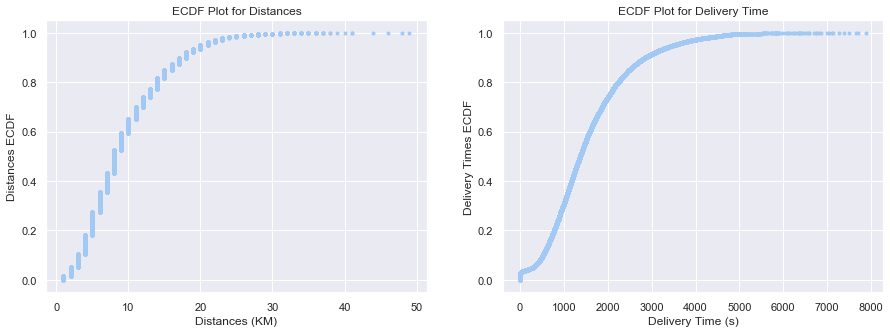

In [0]:
distances = np.sort(train['Distance (KM)'])
distances_ecdf = np.arange(1, len(distances) + 1) / len(distances)
delivery_times = np.sort(train['Time from Pickup to Arrival'])
delivery_times_ecdf = np.arange(1, len(delivery_times) + 1) / len(delivery_times)

fig, (ax1, ax2) = plt.subplots(1,2,figsize=(15,5))
ax1.plot(distances, distances_ecdf, marker='.', linestyle='none')
ax1.set_xlabel('Distances (KM)')
ax1.set_ylabel('Distances ECDF')
ax1.set_title('ECDF Plot for Distances')

ax2.plot(delivery_times, delivery_times_ecdf, marker='.', linestyle='none')
ax2.set_xlabel('Delivery Time (s)')
ax2.set_ylabel('Delivery Times ECDF')
ax2.set_title('ECDF Plot for Delivery Time')

We can see that 60 and 95 percent of deliveries are within 10KM and 20KM respectively.


With the time distributions we see that 60 and 95 percent of the delivery times are within approximately 1500(s) and 3000(s)

### Exploring Day of Month Columns

By just eyeing the first few rows of the data, it seems that the order might tend to be picked up on the same day that the order was placed, which makes sense considering this is an express delivery service.

In [0]:
# Creating a column that calculates the difference between when the
# order was made and when the order was picked up
train['placement_pickup'] = train['Pickup - Day of Month'] - train['Placement - Day of Month']
print(train[train['placement_pickup'] > 0])

# Dropping the calculated column
train.drop(['placement_pickup'], axis=1, inplace=True)

                    User Id Vehicle Type  Platform Type Personal or Business  \
Order No                                                                       
Order_No_2800  User_Id_1402         Bike              3             Business   
Order_No_3530  User_Id_2457         Bike              3             Business   

               Placement - Day of Month  Placement - Weekday (Mo = 1)  \
Order No                                                                
Order_No_2800                        17                             1   
Order_No_3530                        11                             2   

                 Placement - Time  Confirmation - Day of Month  \
Order No                                                         
Order_No_2800 2020-05-28 14:34:37                           18   
Order_No_3530 2020-05-28 12:22:05                           13   

               Confirmation - Weekday (Mo = 1) Confirmation - Time  ...  \
Order No                                      

It seems that there have only been two cases when the order was made and picked up on different days (and the difference was only one or two days). Out of 21201 rows of data, this data seems that it will have minor predictive capabilities.

It can therefore be suggested that when training the model, we only include one Day of Week and Day of Month column because including they will have high multicollinearity with each other.

### Exploring Distributions on Different Days

In [0]:
# Converting relevant columns into categorical data types
train[['Vehicle Type', 'Platform Type', 'Personal or Business']] = train[['Vehicle Type', 'Platform Type', 'Personal or Business']].astype('category')
train[['Placement - Day of Month', 'Placement - Weekday (Mo = 1)', 'Confirmation - Day of Month', 'Confirmation - Weekday (Mo = 1)']] = train[['Placement - Day of Month', 'Placement - Weekday (Mo = 1)', 'Confirmation - Day of Month', 'Confirmation - Weekday (Mo = 1)']].astype('category')
train[['Arrival at Pickup - Day of Month', 'Arrival at Pickup - Weekday (Mo = 1)', 'Arrival at Destination - Day of Month', 'Arrival at Destination - Weekday (Mo = 1)']] = train[['Arrival at Pickup - Day of Month', 'Arrival at Pickup - Weekday (Mo = 1)', 'Arrival at Destination - Day of Month', 'Arrival at Destination - Weekday (Mo = 1)']].astype('category')

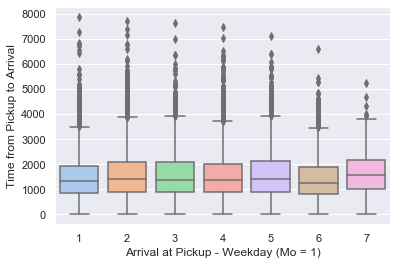

In [0]:
sns.boxplot(x='Arrival at Pickup - Weekday (Mo = 1)', y='Time from Pickup to Arrival', data=train)

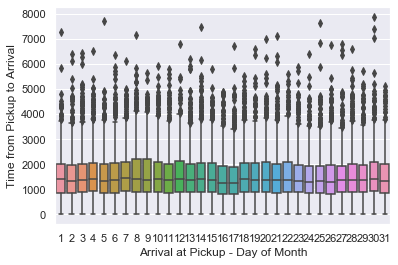

In [0]:
sns.boxplot(x='Arrival at Pickup - Day of Month', y='Time from Pickup to Arrival', data=train)

These boxplots indicate that there doesn't seem to be a huge difference in travel time between the different days. There are quite a number of outliers in each day's category.

### Correlations

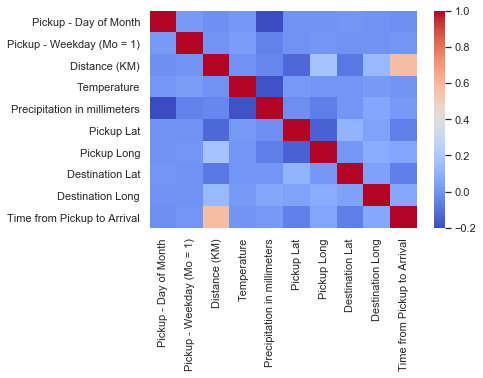

In [0]:
train_corr = train.corr()
sns.heatmap(train_corr, cmap='coolwarm')

## Data preprocessing


In [0]:
def preprocessing(data):
  """ Takes dataframe as input, drops unnecesarry columns and returns train-test split data
  
      Args: pandas dataframe

      Returns: X_train, y_train, X_test, y_test

      Examples:
  
  """

  # standardize features

  # split the dataset into the response, y, and features, X

  # return X_train, y_train, X_test, y_test

### Data Preprocessing utility functions

In [0]:
def change_type_to_category(features_df, columns):
    
    features_df[columns] = features.astype('category')
    return None
    
def select_features(features_df):
    
    features_df = features_df[['Platform Type', 'Personal or Business', 'Pickup - Day of Month', 'Pickup - Weekday (Mo = 1)', 'Pickup - Time', 'Pickup Lat',	'Pickup Long', 'Destination Lat',	'Destination Long', 'Distance (KM)', 'Temperature', 'Precipitation in millimeters']]
    return None
    
def assign_time_category(delivery_time):
    
    dts = pd.DataFrame(['12:00:00 AM', '6:00:00 AM', '9:00:00 AM', '12:00:00 PM', '3:00:00 PM', '6:00:00 PM'])[0].astype('datetime64[ns]')
    
    if delivery_time >= dts[0] and delivery_time < dts[1]:
        return 'Early Morning'
    elif delivery_time >= dts[1] and delivery_time < dts[2]:
        return 'Morning'
    elif delivery_time >= dts[2]  and delivery_time < dts[3]:
        return 'Late Morning'
    elif delivery_time >= dts[3] and delivery_time < dts[4]:
        return 'Afternoon'
    elif delivery_time >= dts[4] and delivery_time < dts[5]:
        return 'Late Afternoon'
    else:
        return 'Evening'
    
def transform_time_feature(feature_df):
    
    feature_df['Delivery Times'] = feature_df['Pickup - Time'].apply(assign_time_category)
    change_type_to_category(features_df, ['Delivery Times'])
    features_df.drop('Pickup - Time', axis=1, inplace=True)
    return None

def encode_features(feature_df):
    
    feature_df = pd.get_dummies(feature_df,
                                columns=['Platform Type', 'Personal or Business', 'Pickup - Day of Month', 'Pickup - Weekday (Mo = 1)', 'Delivery Times'],
                                prefix=['platformtype', 'personalbusiness', 'dayofmonth', 'weekday', 'pickuptimes']
                               )

### Splitting into training features and outputs

In [0]:
training_features = orders.iloc[:, :-1]
training_outputs = orders.iloc[:, -1]

### Deleting an outlier

In [0]:
training_features.drop(11859, inplace=True)
training_outputs.drop(index=11859, inplace=True)

In [0]:
# get X_train, y_train, X_test, y_test 
preprocessing(train)

# plot the training and testing data as scatter plot

## Modelling

### Modelling utility functions

In [0]:
SEED = 3

def train_model(model, features, observations):
    
    return model.fit(features, observations)

def get_model_predictions(model, features):
    
    return model.predict(features)

def get_model_scores(predictions, observations):
    
    model_scores = {
        
        'R2': metrics.r2_score(predictions, observations),
        'MSE': metrics.mean_squared_error(predictions, observations),
        'RMSE': np.sqrt(metrics.mean_squared_error(predictions, observations))
    }
    
    return model_scores

def plot_model_residuals():
    
    pass

### Train-test split

In [0]:
training_features, test_features, training_outputs, test_outputs = train_test_split(training_features, training_outputs, test_size=0.2)

### Simple Linear Regression

In [0]:
# declare the model object
linear_model = LinearRegression()

# fit the model to the training data
linear_model = train_model(training_features['Distance (KM)'], training_outputs)

# get predictions on the test set
train_lm_predictions = get_model_predictions(linear_model, training_features)
test_lm_predictions = get_model_predictions(linear_model, test_features)
zindi_lm_predictions = get_model_predictions(linear_model, test_features)

# calculate performance metrics
train_lm_metrics = get_model_metrics(predictions, training_outputs)
test_lm_metrics = get_model_metrics(predictions, test_outputs)
zindi_lm_metrics = get_model_metrics(predictions, test_outputs)

### Multiple Linear Regression Model

In [0]:
# declare the model object
multiple_linear_model = LinearRegression()

# fit the model to the training data
multiple_linear_model = train_model(training_features, training_outputs)

# get predictions on the test set
train_ml_predictions = get_model_predictions(multiple_linear_model, training_features)
test_ml_predictions = get_model_predictions(multiple_linear_model, test_features)
zindi_ml_predictions = get_model_predictions(multiple_linear_model, test_features)

# calculate performance metrics
train_ml_metrics = get_model_metrics(predictions, training_outputs)
tets_ml_metrics = get_model_metrics(predictions, test_outputs)
zindi_ml_metrics = get_model_metrics(predictions, test_outputs)

### Decision Tree Model

In [0]:
# declare the model object
regression_tree = DecisionTreeRegressor(random_state = SEED)

# fit the model to the training data
regression_tree = train_model(training_features, training_outputs)

# get predictions on the test set
train_dt_predictions = get_model_predictions(regression_tree, training_features)
test_dt_predictions = get_model_predictions(regression_tree, test_features)
zindi_dt_predictions = get_model_predictions(regression_tree, test_features)

# calculate performance metrics
train_dt_metrics = get_model_metrics(predictions, training_outputs)
tets_dt_metrics = get_model_metrics(predictions, test_outputs)
zindi_dt_metrics = get_model_metrics(predictions, test_outputs)

### Random Forest Model

In [0]:
# declare the model object
random_forest = RandomForestRegressor(n_estimators = 200, random_state = SEED)

# fit the model to the training data
random_forest = train_model(training_features, training_outputs)

# get predictions on the test set
train_rf_predictions = get_model_predictions(random_forest, traing_features)
test_rf_predictions = get_model_predictions(random_forest, test_features)
zindi_rf_predictions = get_model_predictions(random_forest, test_features)

# calculate performance metrics
train_rf_metrics = get_model_metrics(predictions, training_outputs)
tets_rf_metrics = get_model_metrics(predictions, test_outputs)
zindi_rf_metrics = get_model_metrics(predictions, test_outputs)

### Lasso Regression Model

In [0]:
# declare the model object

# fit the model to the training data

# get predictions on the test set 

# calculate performance metrics

## Performance evaluation

In [0]:
# plot scatter graph of y_test and y_predict for models

# choose the best model

# saving the model with Pickle

# Restoring the model with Pickle

## Model analysis

In [0]:
# How can model help Sendy?

# How did modelling the traffic help with an accurate model?

#Conclusion


 Did we answer the problem statement?

 Did we create a viable equation of value?